In [42]:
## DSO106 L2 Modeling with Logistic Regression - R
#install.packages("caret")
#install.packages("magrittr")
#install.packages("dplyr")
#install.packages("tidyr")
#install.packages("lmtest")
#install.packages("popbio")
#install.packages("e1071")

In [11]:
# Load in libraries
library("caret")
library("magrittr")
library("dplyr")
library("tidyr")
library("lmtest")
library("popbio")
library("e1071")


Attaching package: ‘popbio’


The following object is masked from ‘package:caret’:

    sensitivity




In [12]:
#Load in baseball data
baseball <- read.csv('../data/baseball.csv')

In [13]:
head(baseball)

,Game,Team,Opp,W.L,R,RA,D.N,Att,Team.1,HR.Count
,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>
1,1,ARI,SFG,W,6,5,D,49016,ARI,1
2,1,CHC,STL,L,3,4,N,47566,CHC,1
3,1,NYY,TBR,L,3,7,D,31042,NYY,0
4,1,SFG,ARI,L,5,6,D,49016,SF,2
5,1,STL,CHC,W,4,3,N,47566,STL,1
6,1,TBR,NYY,W,7,3,D,31042,TB,2


# Determine whether # of home runs hit in a game is a predictor of whether or not a team wins

In [14]:
# Data Wrangling
# recode the outcome variable (DV) to zeroes and ones
baseball$WinsR <- NA
baseball$WinsR[baseball$W.L == 'W'] <- 1
baseball$WinsR[baseball$W.L == 'L'] <- 0

In [15]:
# testing logistic regression assumptions
mylogit <- glm(WinsR ~ HR.Count, data=baseball, family='binomial')

In [16]:
# Predict wins and losses
probabilities <- predict(mylogit, type='response')
# Convert probabilities to have a positive or negative prediction
baseball$Predicted <- ifelse(probabilities > .5, 'pos', 'neg')

In [17]:
# Next, recode the predicted variable
baseball$PredictedR <- NA
baseball$PredictedR[baseball$Predicted == 'pos'] <- 1
baseball$PredictedR[baseball$Predicted == 'neg'] <- 0

In [18]:
# Convert our new variables to factors
baseball$PredictedR <- as.factor(baseball$PredictedR)
baseball$WinsR <- as.factor(baseball$WinsR)

In [19]:
# Create a confusion matrix
conf_mat <- caret::confusionMatrix(baseball$PredictedR, baseball$WinsR)
conf_mat

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1917 1240
         1  513 1190
                                          
               Accuracy : 0.6393          
                 95% CI : (0.6256, 0.6528)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2786          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.7889          
            Specificity : 0.4897          
         Pos Pred Value : 0.6072          
         Neg Pred Value : 0.6988          
             Prevalence : 0.5000          
         Detection Rate : 0.3944          
   Detection Prevalence : 0.6496          
      Balanced Accuracy : 0.6393          
                                          
       'Positive' Class : 0               
                        

In [20]:
# Logit linearity
# calculate the logit and graph it against the predicted values
baseball1 <- baseball %>% dplyr::select_if(is.numeric)

In [21]:
predictors <- colnames(baseball1)

In [22]:
# finally, create the logit
baseball1 <- baseball1 %>%
  mutate(logit=log(probabilities/(1-probabilities))) %>%
  gather(key= 'predictors', value= 'predictor.value', -logit)

In [26]:
# lets reduce the warning level for this next function
options(warn=-1)

`geom_smooth()` using formula 'y ~ x'



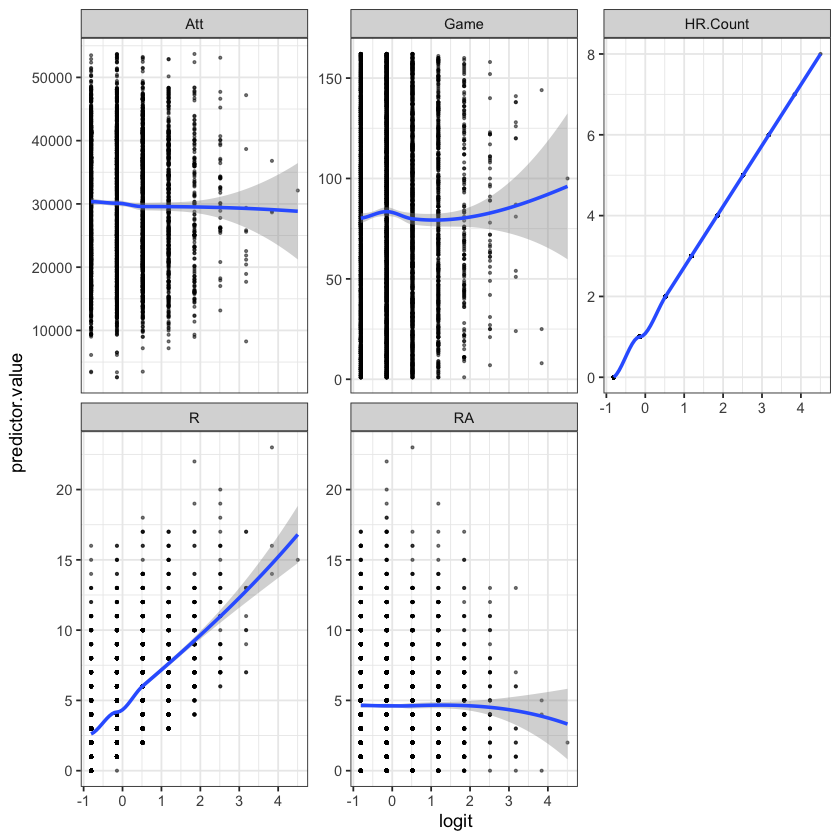

In [27]:
# With this logit in hand, you can graph to assess for linearity
ggplot(baseball1, aes(logit, predictor.value))+
  geom_point(size=.5, alpha=.5)+
  geom_smooth(method= 'loess')+
  theme_bw()+
  facet_wrap(~predictors, scales='free_y')

In [28]:
# lets turn the warnings level back on
options(warn=0)

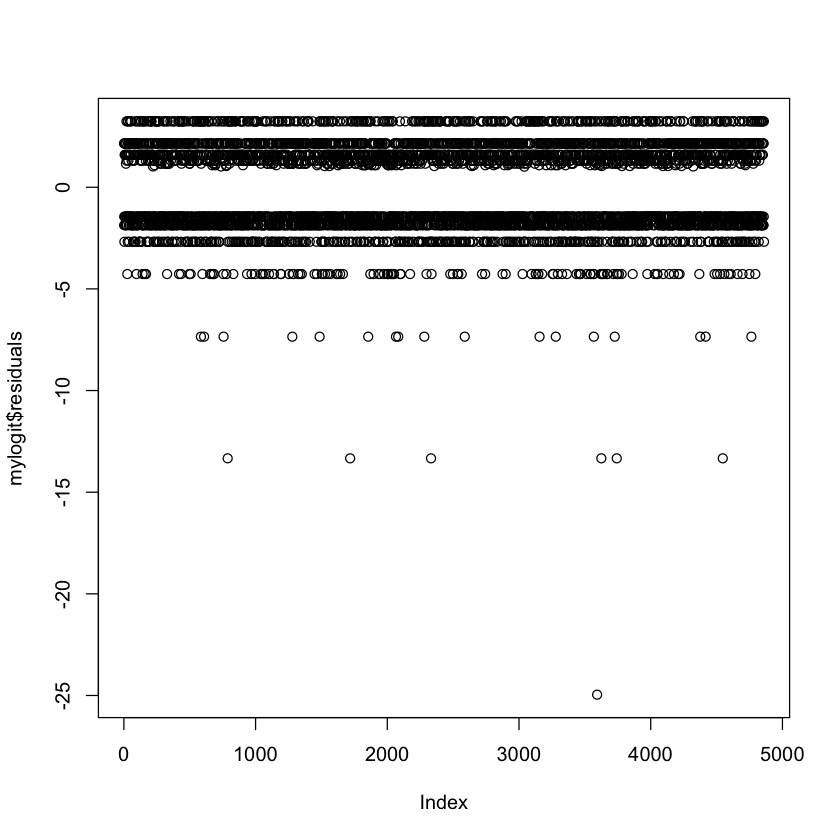

In [29]:
# can skip testing for the assumption of multicollinearity
# BC there is only 1 IV

# Testing for independent errors

plot(mylogit$residuals)
# seeing an even distribution of points across the x axis
# we have met the assumption of independent errors

# Testing for independent error - alternatives


In [30]:
# Durbin-Watson test to check for independence of errors
dwtest(mylogit, alternative='two.sided')


	Durbin-Watson test

data:  mylogit
DW = 2.0828, p-value = 0.003875
alternative hypothesis: true autocorrelation is not 0


In [31]:
# Screening for outliers
infl <- influence.measures(mylogit)
summary(infl)

Potentially influential observations of
	 glm(formula = WinsR ~ HR.Count, family = "binomial", data = baseball) :

     dfb.1_ dfb.HR.C dffit   cov.r   cook.d hat  
16   -0.01   0.01     0.02    1.00_*  0.00   0.00
233  -0.01   0.01     0.01    1.00_*  0.00   0.00
275  -0.01   0.01     0.02    1.00_*  0.00   0.00
285  -0.01   0.01     0.02    1.00_*  0.00   0.00
309  -0.01   0.01     0.02    1.00_*  0.00   0.00
320  -0.01   0.01     0.02    1.00_*  0.00   0.00
327  -0.01   0.01     0.02    1.00_*  0.00   0.00
334  -0.01   0.01     0.02    1.00_*  0.00   0.00
345  -0.01   0.01     0.02    1.00_*  0.00   0.00
437  -0.01   0.01     0.02    1.00_*  0.00   0.00
498  -0.01   0.01     0.02    1.00_*  0.00   0.00
501  -0.01   0.01     0.02    1.00_*  0.00   0.00
586  -0.01   0.01     0.02    1.00_*  0.00   0.00
671  -0.01   0.01     0.01    1.00_*  0.00   0.00
679  -0.01   0.01     0.02    1.00_*  0.00   0.00
684  -0.01   0.01     0.02    1.00_*  0.00   0.00
694  -0.01   0.01     0.01    1.00_

In [51]:
idx <- which(infl$dffit > 0.03 ) # row numbers
head(idx)              # values with names

integer(0)

In [52]:
# Top N highest values by group
data_new2 <- infl %>%  
  arrange(desc(value)) %>% 
  group_by(group) %>%
  slice(1:3)
data_new2  

ERROR: Error in UseMethod("arrange"): no applicable method for 'arrange' applied to an object of class "infl"


In [41]:
# lets see which are most influential
which(apply(infl$is.inf, 1, any))

16  233  275  285  309  320  327  334  345  437  498  501  586  671  679  684 
  16  233  275  285  309  320  327  334  345  437  498  501  586  671  679  684 
 694  698  777  779  788  801  904 1040 1088 1092 1115 1133 1135 1157 1213 1247 
 694  698  777  779  788  801  904 1040 1088 1092 1115 1133 1135 1157 1213 1247 
1251 1258 1273 1277 1280 1282 1326 1330 1348 1370 1377 1385 1467 1474 1524 1539 
1251 1258 1273 1277 1280 1282 1326 1330 1348 1370 1377 1385 1467 1474 1524 1539 
1549 1561 1577 1582 1626 1636 1645 1646 1667 1677 1703 1707 1718 1754 1759 1783 
1549 1561 1577 1582 1626 1636 1645 1646 1667 1677 1703 1707 1718 1754 1759 1783 
1811 1827 1835 1849 1853 1860 1862 1867 1879 1901 1914 1994 2004 2011 2017 2023 
1811 1827 1835 1849 1853 1860 1862 1867 1879 1901 1914 1994 2004 2011 2017 2023 
2033 2038 2043 2067 2080 2106 2148 2154 2175 2206 2226 2254 2289 2332 2357 2390 
2033 2038 2043 2067 2080 2106 2148 2154 2175 2206 2226 2254 2289 2332 2357 2390 
2410 2427 2496 2500 2525 2538 2573 2633 2643 2657 2744 2764 2773 2809 2814 2831 
2410 2427 2496 2500 2525 2538 2573 2633 2643 2657 2744 2764 2773 2809 2814 2831 
2833 2890 2917 2920 2936 2966 2992 3009 3039 3060 3121 3153 3207 3243 3275 3293 
2833 2890 2917 2920 2936 2966 2992 3009 3039 3060 3121 3153 3207 3243 3275 3293 
3315 3325 3353 3398 3400 3410 3513 3540 3577 3588 3592 3593 3615 3620 3625 3629 
3315 3325 3353 3398 3400 3410 3513 3540 3577 3588 3592 3593 3615 3620 3625 3629 
3655 3670 3705 3714 3735 3741 3742 3755 3781 3795 3841 3867 3903 3920 3948 3950 
3655 3670 3705 3714 3735 3741 3742 3755 3781 3795 3841 3867 3903 3920 3948 3950 
3959 4034 4056 4081 4090 4093 4121 4124 4129 4131 4186 4193 4218 4234 4279 4280 
3959 4034 4056 4081 4090 4093 4121 4124 4129 4131 4186 4193 4218 4234 4279 4280 
4383 4385 4397 4406 4461 4467 4525 4539 4547 4577 4614 4681 4685 4716 4719 4779 
4383 4385 4397 4406 4461 4467 4525 4539 4547 4577 4614 4681 4685 4716 4719 4779

In [32]:
## Running Logistic Regression and Interpreting the Output
summary(mylogit)


Call:
glm(formula = WinsR ~ HR.Count, family = "binomial", data = baseball)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5366  -1.1171  -0.3553   1.2389   1.5338  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.80749    0.04658  -17.34   <2e-16 ***
HR.Count     0.66398    0.03044   21.81   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 6737.4  on 4859  degrees of freedom
Residual deviance: 6161.4  on 4858  degrees of freedom
AIC: 6165.4

Number of Fisher Scoring iterations: 4


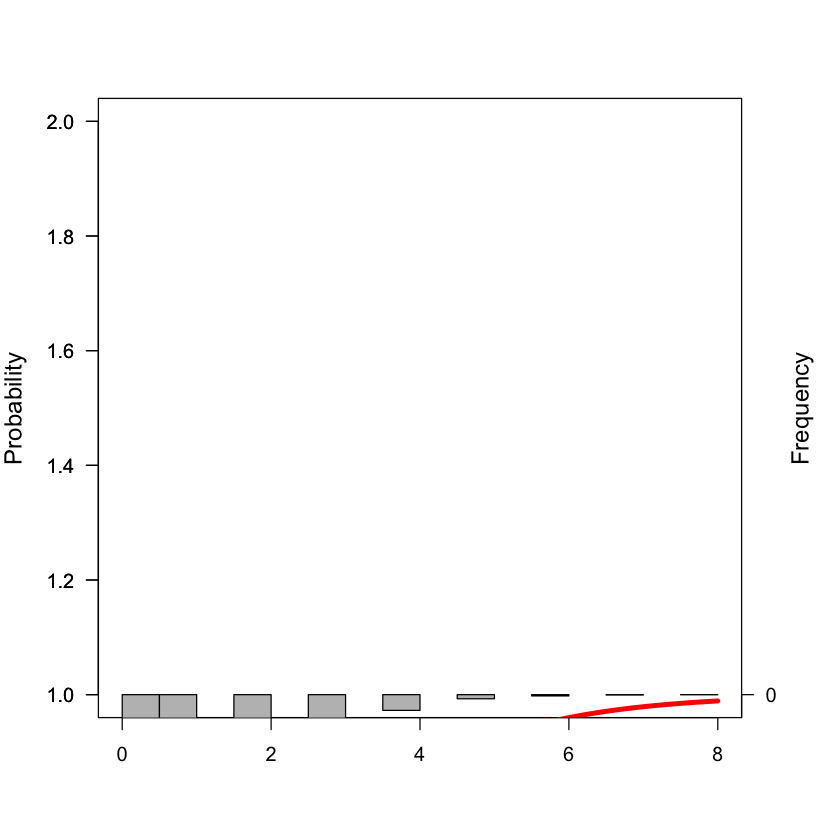

In [33]:
# Graphing the logistic model
logi.hist.plot(baseball$HR.Count,baseball$WinsR, boxp=FALSE, type="hist", col="gray")